# Create SODAbot HuggingFace Dataset
**Link to dataset repository:** https://huggingface.co/datasets/kim-sha/text-to-socrata-sql

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [56]:
import os
import json
import requests
import pandas as pd
import plotly.express as px
from sodapy import Socrata

from datasets import Dataset

from tqdm.notebook import tqdm
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

We're going to create exemplary records for 10 of the most popular NYC Open datasets. Each datum must be structured as follows:
```
{
    'question': <natural language question which describes what we're trying to learn about a table with schema: 'context'>,
    'context': [(<field1>, <dtype1>), (<field2>, <dtype2>), ...]
    'answer': {
        'query': <Socrata SQL query to answer the question>,
        'plot': <Python code to generate a Plotly figure for the output of the query>
    }
}
```

In order to cover a diverse set of queries, our current variations include:
- Basic `SELECT` statements including `WHERE` clauses
- Aggregations such as `COUNT` that involve `GROUP BY` clauses
- Trends over `date` fields

## Helpers

In [4]:
def format_schema(response):
    cols = [
        'dataTypeName',
        # 'description',
        'fieldName'
    ]
    # We're going to sort in reverse s.t. schema is always returned in order of fieldName, description, datatype
    return [
        tuple(v.strip() for k, v in sorted(d.items(), reverse=True) if k in cols) \
        for d in response.json()['columns'] if 'computationStrategy' not in d.keys()
    ]

In [5]:
def clean_dtypes(df):

    int_columns = ['volume']
    dt_columns = ['year', 'year_month']

    df = df.astype({col: int for col in int_columns if col in df.columns})\
           .astype({col: 'datetime64[ns]' for col in dt_columns if col in df.columns})
    return df

## [For Hire Vehicles (FHV) - Active](https://data.cityofnewyork.us/Transportation/For-Hire-Vehicles-FHV-Active/8wbx-tsch)

In [58]:
endpoint = '8wbx-tsch'
response = requests.get(f"https://data.cityofnewyork.us/views/{endpoint}.json")
with open('schemas/fhv_schema.json', 'w') as f:
    json.dump(response.json()['columns'], f)
context = str(format_schema(response))

# Total number of records in this dataset
num_records = int(client.get(endpoint, query="SELECT COUNT(*)")[0]['COUNT'])
print(num_records)

# Our dataset will be a list of dicts
dataset_fhv = []

105862


### SELECT

In [20]:
datum = {
    'question':'What are the different license types?',
    'context': context,
    'answer':{
        'query': """SELECT DISTINCT license_type ORDER BY license_type ASC""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df

,license_type
0,FOR HIRE VEHICLE


In [21]:
datum = {
    'question':'What are the base unique types of vehicles?',
    'context': context,
    'answer':{
        'query': """SELECT DISTINCT base_type ORDER BY base_type ASC""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df

,base_type
0,BLACK-CAR
1,LIVERY
2,LUXURY


In [22]:
datum = {
    'question':'Select the date and VIN numbers for vehicles that are expiring in January 2024.',
    'context': context,
    'answer':{
        'query': """SELECT expiration_date, vehicle_vin_number
WHERE DATE_EXTRACT_Y(expiration_date) = 2024
AND DATE_EXTRACT_M(expiration_date) = 1""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df = clean_dtypes(df)
df.head()

,expiration_date,vehicle_vin_number
0,2024-01-21T00:00:00.000,1FMCU4K32AKA36211
1,2024-01-23T00:00:00.000,2G1WC5E39D1139774
2,2024-01-24T00:00:00.000,4T1BF1FK9EU471470
3,2024-01-21T00:00:00.000,4T1BD1FK2FU167968
4,2024-01-20T00:00:00.000,4T1BF1FK5GU159732


In [23]:
datum = {
    'question':'Select all records for FHV permits associated with UBER USA, LLC.',
    'context': context,
    'answer':{
        'query': """SELECT * WHERE base_name = 'UBER USA, LLC'""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df = clean_dtypes(df)
df.head()

,active,vehicle_license_number,name,license_type,expiration_date,permit_license_number,dmv_license_plate_number,vehicle_vin_number,certification_date,hack_up_date,...,base_number,base_name,base_type,base_telephone_number,base_address,reason,last_date_updated,last_time_updated,veh,wheelchair_accessible
0,YES,5831778,"CIPRIAN,RAMON,S",FOR HIRE VEHICLE,2025-11-30T00:00:00.000,AC654,T750446C,4T1BF1FK7CU570902,2018-09-05T00:00:00.000,2017-11-22T00:00:00.000,...,B03404,"UBER USA, LLC",BLACK-CAR,(646)780-0129,1515 THIRD STREET SAN FRANCISCO CA 94158,G,2024-01-18T00:00:00.000,13:25,NaN,NaN
1,YES,5771246,"MUSTAFA,FADA,UL",FOR HIRE VEHICLE,2025-03-21T00:00:00.000,AD061,T737270C,4T1BF1FK9FU026700,2019-08-21T00:00:00.000,2017-03-21T00:00:00.000,...,B03404,"UBER USA, LLC",BLACK-CAR,(646)780-0129,1515 THIRD STREET SAN FRANCISCO CA 94158,G,2024-01-18T00:00:00.000,13:25,NaN,NaN
2,YES,5961607,"SAHI,SHAHZAD,IQBAL",FOR HIRE VEHICLE,2024-04-01T00:00:00.000,AE417,T790959C,4T1BD1FK5EU099552,2020-03-18T00:00:00.000,2020-04-01T00:00:00.000,...,B03404,"UBER USA, LLC",BLACK-CAR,(646)780-0129,1515 THIRD STREET SAN FRANCISCO CA 94158,G,2024-01-18T00:00:00.000,13:25,HYB,NaN
3,YES,5522853,"AYAD,TIMOTHAOS",FOR HIRE VEHICLE,2026-01-22T00:00:00.000,AF049,T637895C,4T1BF3EK2AU551345,2014-01-17T00:00:00.000,2014-01-22T00:00:00.000,...,B03404,"UBER USA, LLC",BLACK-CAR,(646)780-0129,1515 THIRD STREET SAN FRANCISCO CA 94158,G,2024-01-18T00:00:00.000,13:25,NaN,NaN
4,YES,5684369,"GAYE,ABDOULAYE",FOR HIRE VEHICLE,2024-03-22T00:00:00.000,BA532,T692326C,4T1BF1FK7EU309532,2022-11-22T00:00:00.000,2016-03-22T00:00:00.000,...,B03404,"UBER USA, LLC",BLACK-CAR,(646)780-0129,1515 THIRD STREET SAN FRANCISCO CA 94158,G,2024-01-18T00:00:00.000,13:25,NaN,NaN


### Aggregate

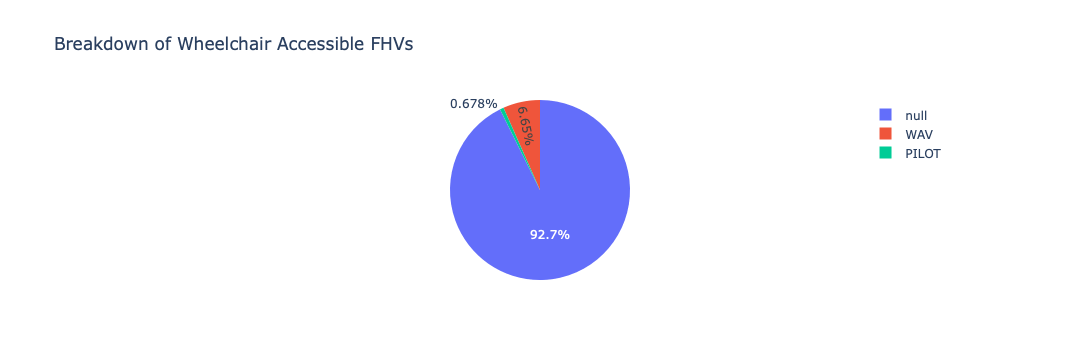

In [24]:
datum = {
    'question':'What is fraction of vehicles are wheelchair accessible?',
    'context': context,
    'answer':{
        'query': """SELECT wheelchair_accessible, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY wheelchair_accessible""",
        'plot': """fig = px.pie(df, names='wheelchair_accessible', values='volume', title='Breakdown of Wheelchair Accessible FHVs')"""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df = clean_dtypes(df)
exec(datum['answer']['plot'])
fig

In [25]:
datum = {
    'question':'How many permits were ordered for suspension in 2023?',
    'context': context,
    'answer':{
        'query': """SELECT COUNT(*) WHERE DATE_EXTRACT_Y(order_date) = 2023""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df

,COUNT
0,0


In [26]:
datum = {
    'question':'How many records are in this dataset?',
    'context': context,
    'answer':{
        'query': """SELECT COUNT(*)""",
        'plot': ""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df

,COUNT
0,105548


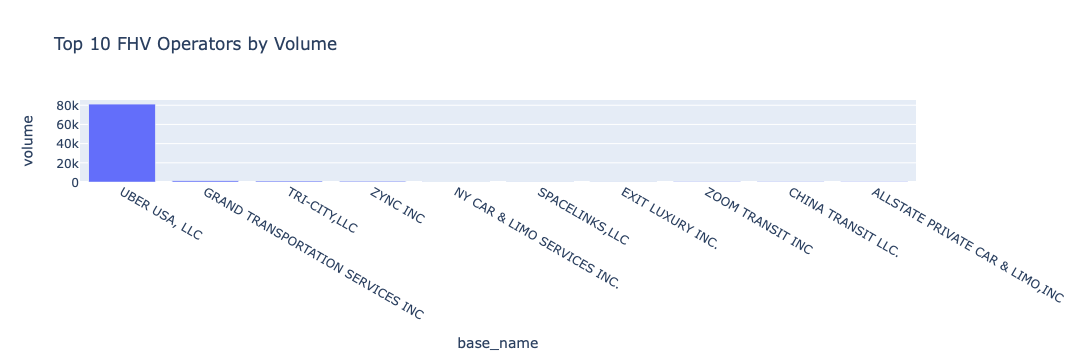

In [27]:
datum = {
    'question':'Who are the top 10 operators of for-hire vehicles in NYC?',
    'context': context,
    'answer':{
        'query': """SELECT base_name, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY base_name
ORDER BY volume DESC
LIMIT 10""",
        'plot': """fig = px.bar(df, x='base_name', y='volume', title='Top 10 FHV Operators by Volume')"""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df = clean_dtypes(df)
exec(datum['answer']['plot'])
fig

### Trends

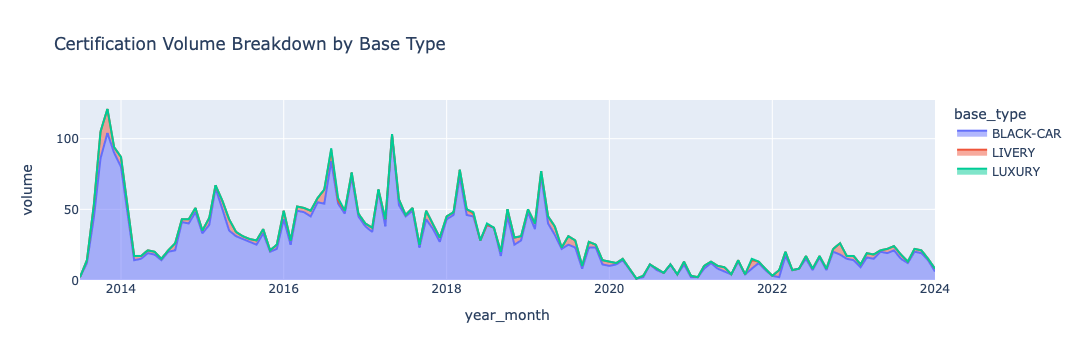

In [28]:
datum = {
    'question':'What is the breakdown of vehicle base types that get certified over time?',
    'context': context,
    'answer':{
        'query': """SELECT DATE_TRUNC_YM(certification_date) AS year_month, base_type, COUNT(*) as volume
GROUP BY DATE_TRUNC_YM(certification_date), base_type
ORDER BY DATE_TRUNC_YM(certification_date), base_type""",
        'plot': """fig = px.area(df, x='year_month', y='volume', color='base_type', title='Certification Volume Breakdown by Base Type')"""
    }
}
dataset_fhv.append(datum)
df = pd.DataFrame.from_records(client.get(endpoint, query=datum['answer']['query']))
df = clean_dtypes(df)
exec(datum['answer']['plot'])
fig

## [DOB Job Application Filings](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2)

## [311 Service Requests from 2010 to Present](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)

In [30]:
endpoint = 'erm2-nwe9' # NYC 311
response = requests.get(f"https://data.cityofnewyork.us/views/{endpoint}.json")
context = str(format_schema(response))

# Total number of records in this dataset
num_records = int(client.get(endpoint, query="SELECT COUNT(*)")[0]['COUNT'])
print(num_records)

# Our dataset will be a list of dicts
dataset_311 = []

35329250


### SELECT

In [31]:
datum = {
    'question':'What years does this dataset cover?',
    'context': context,
    'answer':{
        'query': """SELECT DISTINCT DATE_EXTRACT_Y(created_date) AS year
ORDER BY DATE_EXTRACT_Y(created_date) DESC""",
        'plot': ""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df

,year
0,2024
1,2023
2,2022
3,2021
4,2020
5,2019
6,2018
7,2017
8,2016
9,2015


### COUNT

**Let's count the number of records grouped by:**

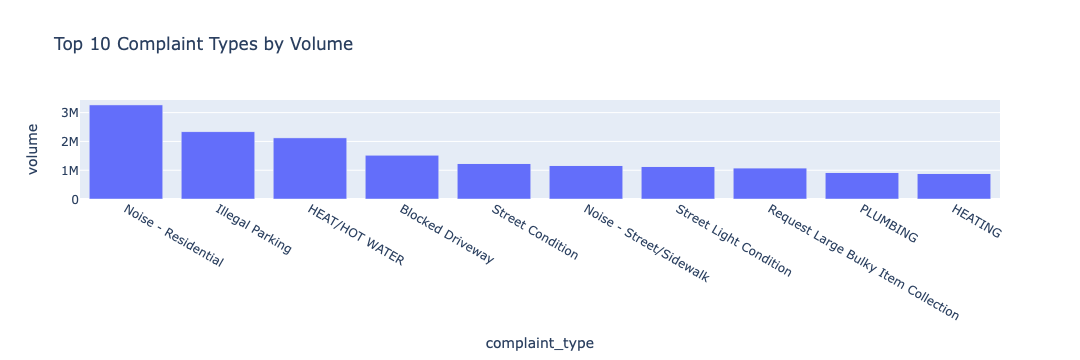

In [32]:
datum = {
    'question':'What are the top 10 complaint types by volume?',
    'context': context,
    'answer':{
        'query': """SELECT complaint_type, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY complaint_type
ORDER BY volume DESC
LIMIT 10""",
        'plot': """fig = px.bar(df, x='complaint_type', y='volume', title='Top 10 Complaint Types by Volume')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'volume': int})
exec(datum['answer']['plot'])
fig

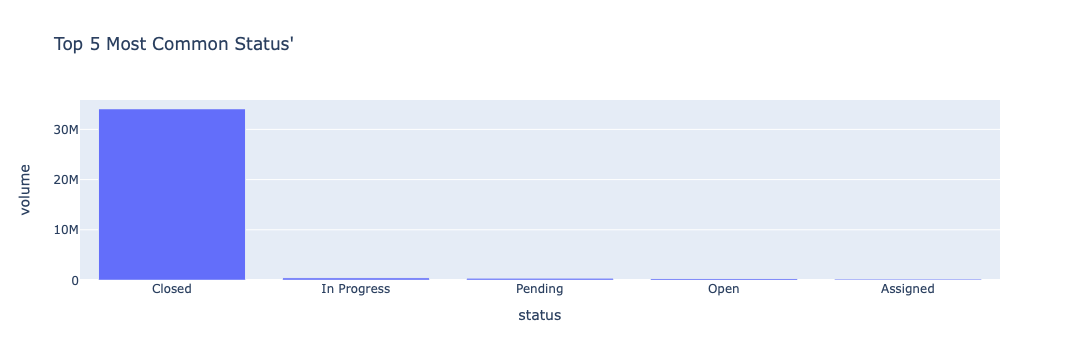

In [33]:
datum = {
    'question':"What are the top 5 most common status'?",
    'context': context,
    'answer':{
        'query': """SELECT status, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY status
ORDER BY volume DESC
LIMIT 5""",
        'plot': """fig = px.bar(df, x='status', y='volume', title="Top 5 Most Common Status'")"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'volume':int})
exec(datum['answer']['plot'])
fig

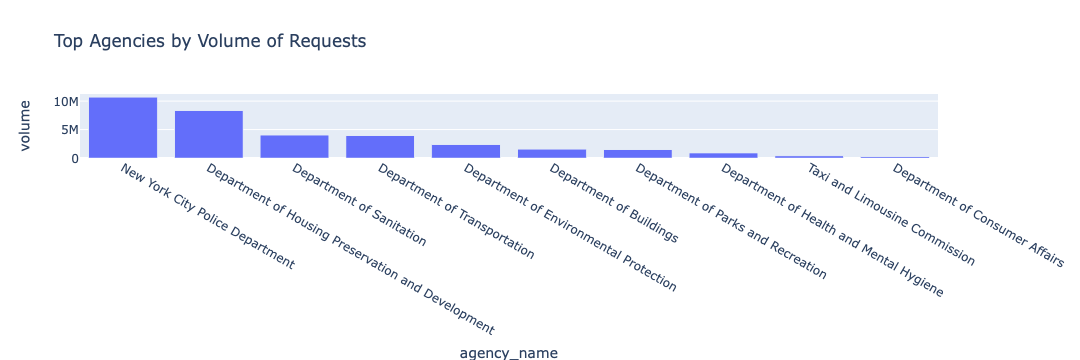

In [34]:
datum = {
    'question':'Which agencies handle the most volume of requests?',
    'context': context,
    'answer':{
        'query': """SELECT agency_name, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY agency_name
ORDER BY volume DESC
LIMIT 10""",
        'plot': """fig = px.bar(df, x='agency_name', y='volume', title='Top Agencies by Volume of Requests')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'volume':int})
exec(datum['answer']['plot'])
fig

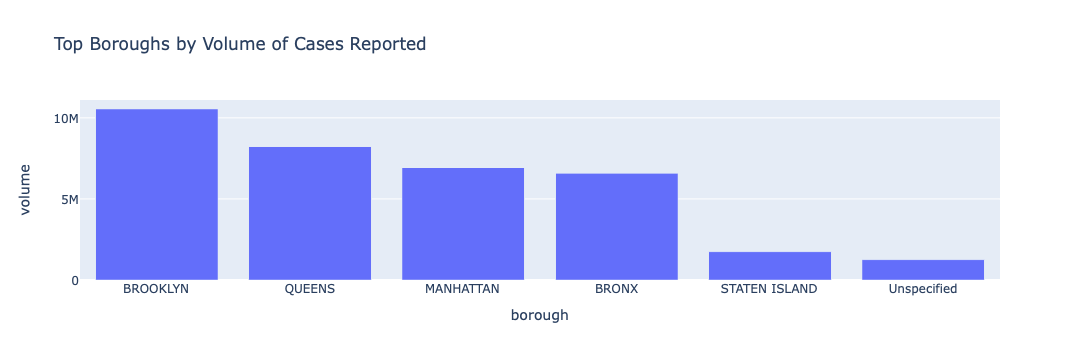

In [35]:
datum = {
    'question':'Which boroughs report the most cases?',
    'context': context,
    'answer':{
        'query': """SELECT borough, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY borough
ORDER BY volume DESC
LIMIT 10""",
        'plot': """fig = px.bar(df, x='borough', y='volume', title='Top Boroughs by Volume of Cases Reported')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'volume':int})
exec(datum['answer']['plot'])
fig

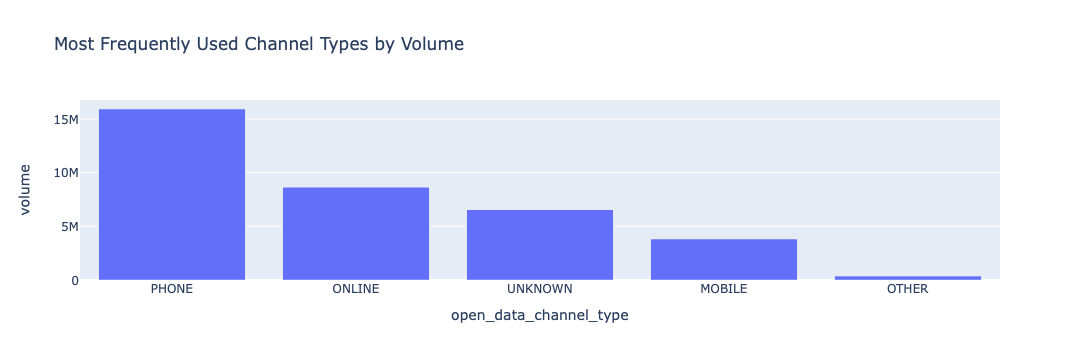

In [36]:
datum = {
    'question':'What are the most frequently used channel types?',
    'context': context,
    'answer':{
        'query': """SELECT open_data_channel_type, COUNT(*) as volume, COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY open_data_channel_type
ORDER BY volume DESC
LIMIT 10""",
        'plot': """fig = px.bar(df, x='open_data_channel_type', y='volume', title='Most Frequently Used Channel Types by Volume')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'volume': int})
exec(datum['answer']['plot'])
fig

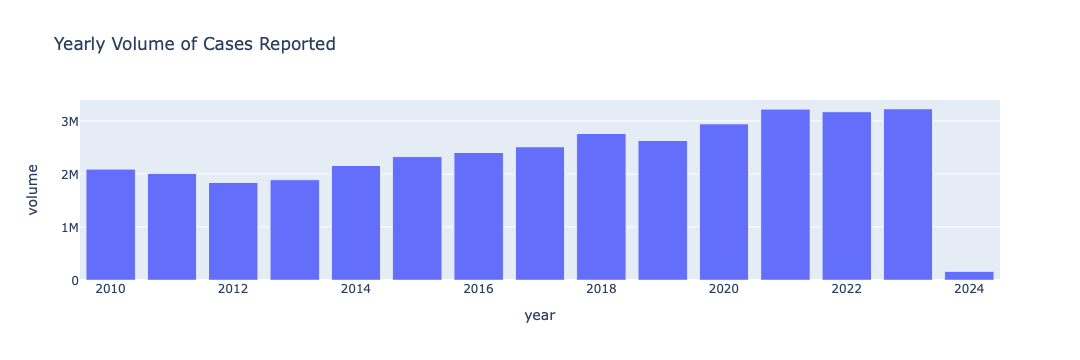

In [37]:
datum = {
    'question':'What is the yearly volume of cases reported?',
    'context': context,
    'answer':{
        'query': """SELECT
    DATE_EXTRACT_Y(created_date) AS year,
    COUNT(*) as volume,
    COUNT(*) / SUM(COUNT(*)) over () AS fraction
GROUP BY DATE_EXTRACT_Y(created_date)
ORDER BY DATE_EXTRACT_Y(created_date) DESC""",
        'plot': """fig = px.bar(df, x='year', y='volume', title='Yearly Volume of Cases Reported')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'year':'datetime64[ns]', 'volume':int})
exec(datum['answer']['plot'])
fig

### Trends

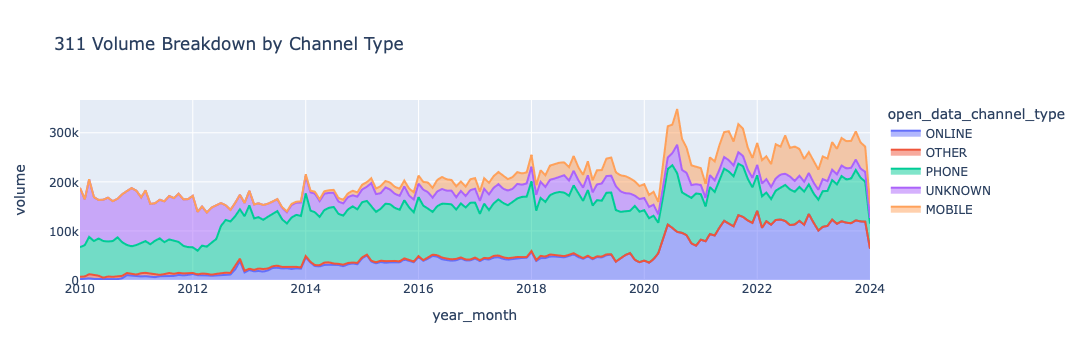

In [38]:
datum = {
    'question':'What is the volume of requests broken down by channel type over time?',
    'context': context,
    'answer':{
        'query': """SELECT DATE_TRUNC_YM(created_date) AS year_month, open_data_channel_type, COUNT(*) as volume
GROUP BY DATE_TRUNC_YM(created_date), open_data_channel_type
ORDER BY DATE_TRUNC_YM(created_date), open_data_channel_type""",
        'plot': """fig = px.area(df, x='year_month', y='volume', color='open_data_channel_type', title='311 Volume Breakdown by Channel Type')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'year_month':'datetime64[ns]', 'volume':int})
exec(datum['answer']['plot'])
fig

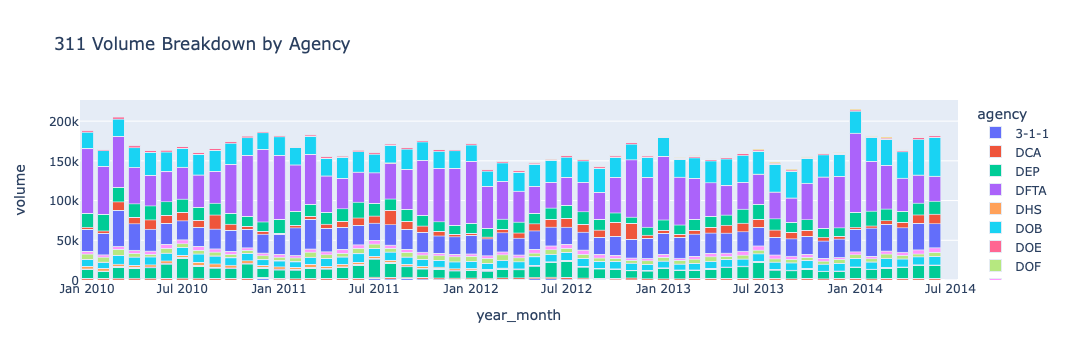

In [39]:
datum = {
    'question':'How has the volume of requests fielded by agencies changed over time?',
    'context': context,
    'answer':{
        'query': """SELECT DATE_TRUNC_YM(created_date) AS year_month, agency, COUNT(*) as volume
GROUP BY DATE_TRUNC_YM(created_date), agency
ORDER BY DATE_TRUNC_YM(created_date), agency""",
        'plot': """fig = px.bar(df, x='year_month', y='volume', color='agency', title='311 Volume Breakdown by Agency')"""
    }
}
dataset_311.append(datum)
df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
df = df.astype({'year_month':'datetime64[ns]', 'volume':int})
exec(datum['answer']['plot'])
fig

In [40]:
# datum = {
#     'question':'How have the complaint types changed over time? Are there any spikes in volume for specific complaints?',
#     'context': context,
#     'answer':{
#         'query': """SELECT DATE_TRUNC_YM(created_date) AS year_month, agency, COUNT(*) as volume
# GROUP BY DATE_TRUNC_YM(created_date), agency
# ORDER BY DATE_TRUNC_YM(created_date), agency""",
#         'plot': """fig = px.bar(df, x='year_month', y='volume', color='agency', title='311 Volume Breakdown by Agency')"""
#     }
# }

# df = pd.DataFrame.from_records(client.get("erm2-nwe9", query=datum['answer']['query']))
# df = df.astype({'year_month':'datetime64[ns]', 'volume':int})
# exec(datum['answer']['plot'])
# fig

In [41]:
# %%time
# query = f"""
#     SELECT
#         DATE_TRUNC_YM(created_date) AS year_month, complaint_type, COUNT(*) AS volume
#     GROUP BY DATE_TRUNC_YM(created_date), complaint_type
#     HAVING complaint_type in ({','.join([f"'{i}'" for i in df_dict['complaint_type'].complaint_type.values])})
#     ORDER BY DATE_TRUNC_YM(created_Date), complaint_type
# """
# df_dict['2.2.3'] = pd.DataFrame.from_records(client.get("erm2-nwe9", query=query))

In [42]:
# df_dict['2.2.3'] = df_dict['2.2.3'].astype({'year_month':'datetime64[ns]', 'volume':int})
# fig = px.area(df_dict['2.2.3'], x='year_month', y='volume', color='complaint_type',
#               title='311 Volume Breakdown by Complaint Type', height=750)
# fig.show()

### GPT-4

In [44]:
with open('schemas/311_schema.json', 'w') as f:
    json.dump(response.json()['columns'], f)

In [45]:
cols = ['question', 'answer']
prompt_dataset = [{k:v for k, v in sorted(d.items(), reverse=True) if k in cols} for d in dataset_311]
with open('prompt_dataset.json', 'w') as f:
    json.dump(prompt_dataset, f)

**Now, let's evaluate the responses we generated via prompt-engineering**

In [46]:
with open('data/generated_311.json') as f:
    datum = json.load(f)

In [47]:
test = []
for example in tqdm(datum):
    try:
        test.append(pd.DataFrame.from_records(client.get("erm2-nwe9", query=example['answer']['query'])))
    except:
        print(example)

  0%|          | 0/10 [00:00<?, ?it/s]

{'question': 'What is the average resolution time for service requests?', 'answer': {'query': 'SELECT AVG(resolution_time) as average_resolution_time', 'plot': "fig = px.histogram(df, x='average_resolution_time', title='Average Resolution Time for Service Requests')"}}
{'question': 'Display the trend of service requests over the years.', 'answer': {'query': 'SELECT EXTRACT(YEAR FROM created_date) as year, COUNT(*) as count GROUP BY year', 'plot': "fig = px.line(df, x='year', y='count', title='Trend of Service Requests Over the Years')"}}
{'question': 'How many service requests were closed within a day?', 'answer': {'query': 'SELECT COUNT(*) WHERE resolution_time <= 1', 'plot': "fig = px.bar(df, x='resolution_time', y='count', title='Service Requests Closed Within a Day')"}}


In [48]:
datum[4]#['answer']['query']

{'question': 'How many service requests were related to noise complaints?',
 'answer': {'query': "SELECT COUNT(*) WHERE complaint_type = 'Noise - Residential'",
  'plot': "fig = px.bar(df, x='complaint_type', y='count', title='Noise Complaints Service Requests')"}}

## [Citywide Payroll Data (Fiscal Year)](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e)

## [Motor Vehicle Collisions - Crashes](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95)

## [New York City Leading Causes of Death](https://data.cityofnewyork.us/Health/New-York-City-Leading-Causes-of-Death/jb7j-dtam)

## [DOHMH New York City Restaurant Inspection Results](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j)

## [NYPD Arrest Data (Year to Date)](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc)

## [COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3)

## [Evictions](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4)

# Write Output

**Our training data is a mixture of manually written JSONs and examples generated (with these manual records) via prompt engineering, with the following prompt:**

`prompt_dataset.json` is a JSON where each record is structured as such:
```
[{
    'question': <natural language question about a table>,
    'answer': {
        'query': <Socrata SQL query to answer the question>,
        'plot': <Python code to generate a Plotly figure for the output of the query>
    }
}]
```
where the queries and columns names are pulled from the table described by `schema.json`.

You are a training data writer. When prompted to generate examples, you will output a JSON to serve as training data. These should be variations of questions humans may ask and corresponding SQL and Plotly code to execute.

You must abide by the following constraints:
- The output should be 1 continuous JSON object.
- The training data must match the JSON format of `sodabot_training_data.json`.
- Any code you produce must be syntactically correct and executable.
- Do not include import statements in any code.
- Any specific columns referenced MUST be present in the table `schema.json`. 

Simulate and output a JSON snippet with 10 examples.

In [49]:
dataset = dataset_fhv + dataset_311

In [51]:
with open('data/sodabot_training_data.json', 'w') as handle:
    json.dump(dataset, handle)

In [54]:
hf_dataset = Dataset.from_list(dataset)
hf_dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 18
})

In [55]:
hf_dataset.push_to_hub('Kim-Sha/text-to-socrata-sql')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/866 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kim-sha/text-to-socrata-sql/commit/f149b64cb41db16d51ec2aeeb1b67ce338fab084', commit_message='Upload dataset', commit_description='', oid='f149b64cb41db16d51ec2aeeb1b67ce338fab084', pr_url=None, pr_revision=None, pr_num=None)